<a href="https://colab.research.google.com/github/BlackCurrantDS/DBSE_Project/blob/main/optics%2Bevaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading Feature vector

In [1109]:
def string_2_itemset(key):
    if key == '':
        return []
    else: 
        return key.split(',')

def itemset_2_string(itemset):
    return ",".join(itemset)

In [1110]:


class AssociationRule:
    def __init__(self, left, right):
        self.left_items = left
        self.right_items = right
        self.scores = []
        
    def length(self):
        return len(self.left_items) + len(self.right_items)
     
    def score(self, index):
        return self.scores[index]
    
    def lhs_string(self):
        return itemset_2_string(self.left_items)
        
    def rhs_string(self):
        return itemset_2_string(self.right_items)
    
    def serialize(self):
        left_key = self.lhs_string()
        right_key = self.rhs_string()
        return left_key + ">" + right_key
    
    @staticmethod        
    def string_2_rule(s):
        subStrings = s.split(">")
        left = string_2_itemset(subStrings[0].strip())
        right = string_2_itemset(subStrings[1].strip())
        #print("AssociationRule(left, right",AssociationRule(left, right))
        return AssociationRule(left, right)

    def append_score(self, score):
        self.scores.append(score)
        
    def get_itemset(self):
        itemset = []
        itemset.extend(self.left_items)
        itemset.extend(self.right_items)
        itemset.sort()
        return itemset
        
        
    def rule_itemset_2_string(self):
        itemset = self.get_itemset()
        return itemset_2_string(itemset)
    
    def compute_basic_probs(self,frequent_itemsets, nTransactions):  
        
        left = frequent_itemsets[self.lhs_string()]
        right = frequent_itemsets[self.rhs_string()]
        
        both = frequent_itemsets[self.rule_itemset_2_string()]
        
        vector = {}
        
        ''' 1. P(A)'''
        p_A = left/nTransactions
        vector['A'] = p_A
        
        ''' 2. P(B)'''
        p_B = right/nTransactions
        vector['B'] = p_B
        
        ''' 3. P(~A)'''
        p_not_A = 1 - p_A
        vector['~A'] = p_not_A
        
        ''' 4. P(~B)'''
        p_not_B = 1 - p_B
        vector['~B'] = p_not_B
        
        ''' 5. P(AB) '''
        p_A_and_B = both/nTransactions
        vector['AB'] = p_A_and_B
        
        ''' 6. P(~AB)'''
        p_not_A_and_B = (right - both)/nTransactions
        vector['~AB'] = p_not_A_and_B
        
        ''' 7. P(A~B)'''
        p_A_and_not_B = (left - both)/nTransactions
        vector['A~B'] = p_A_and_not_B
        
        ''' 8. P(~A~B)'''
        p_not_A_and_not_B = 1 - (left + right - both)/nTransactions
        vector['~A~B'] = p_not_A_and_not_B 
        
        '''
        9. P(A|B)
        '''
        p_A_if_B = p_A_and_B / p_B
        vector['A|B'] = p_A_if_B
        
        '''
        10. P(~A|~B)
        '''
        p_not_A_if_not_B = p_not_A_and_not_B / p_not_B
        vector['~A|~B'] = p_not_A_if_not_B
        
        '''
        11. P(A|~B)
        '''
        p_A_if_not_B = p_A_and_not_B/p_not_B
        vector['A|~B'] = p_A_if_not_B
        
        '''
        12. p(~A|B)
        '''
        p_not_A_if_B = p_not_A_and_B / p_B
        vector['~A|B'] = p_not_A_if_B
        
        '''
        13. P(B|A)
        '''
        p_B_if_A = p_A_and_B / p_A
        vector['B|A'] = p_B_if_A
        
        '''
        14. P(~B|~A)
        '''
        p_not_B_if_not_A = p_not_A_and_not_B / p_not_A
        vector['~B|~A'] = p_not_B_if_not_A
        
        '''
        15. P(B|~A)
        '''
        p_B_if_not_A = p_not_A_and_B/p_not_A
        vector['B|~A'] = p_B_if_not_A
        
        '''
        16. p(~B|A)
        '''
        p_not_B_if_A = p_A_and_not_B / p_A
        vector['~B|A'] = p_not_B_if_A
        
        return vector
    
    def is_redundant_(self, bits, k, itemset, freq_itemset_dict): 
        '''
        Run out of items --> create rule and check format criterion
        '''
        if k >= len(itemset):
            items_1 = []
            items_2 = []
            for index in range(len(bits)):
                if bits[index] == True:
                    items_1.append(itemset[index])
                else:
                    items_2.append(itemset[index])
            for item in items_2:
                rule = AssociationRule(items_1, [item])
                confidence = freq_itemset_dict.getConfidence(rule)
                if confidence == 1: return True
            return False 
      
        value_domain = [True, False]
        for value in value_domain:
            bits[k] = value
            checker = self.is_redundant_(bits, k+1, itemset, freq_itemset_dict)
            if checker == True: return True
            bits[k] = True    
        return False
    
    '''
    Expand an item-set with equivalent items.
    '''
    def is_redundant(self, freq_itemset_dict):
        bits = [True for _ in self.left_items]
        checker = self.is_redundant_(bits, 0, self.left_items, freq_itemset_dict)
        if checker == True: return True
        
        bits =  [True for _ in self.right_items]
        return self.is_redundant_(bits, 0, self.right_items, freq_itemset_dict)
    
    '''
    Check if an item-set is satisfied condition of the rule. 
    '''
    def satisfy_rule(self, itemset, is_lhs = True):
        condition = self.left_items
        if is_lhs == False: condition = self.right_items
        if len(condition) > len(itemset) or len(itemset) == 0:
            return False
        for item in condition:
            if item not in itemset:
                return False
        return True
    

In [1111]:
def string_2_rule(s):
        subStrings = s.split(">")
        left = string_2_itemset(subStrings[0].strip())
        right = string_2_itemset(subStrings[1].strip())
        return AssociationRule(left, right)

In [1112]:
 import json
 import numpy as np
 def load_feature_vectors():
        data = []
        lengths = []
        
        with open("/content/miner.tmp.non_redundant_rules", 'r') as feature_reader:
            print('Loading number of LHS and RHS features...')
            lhs_count = int(feature_reader.readline())
            rhs_count = int(feature_reader.readline())
            print('Loading feature vectors... ')
            for line in feature_reader:
                rule_text, f_vector = json.loads(line.strip())
                rule = string_2_rule(rule_text.strip())
                lengths.append(rule.length())
                #print(rule) this rule as an object of the assocition rule class
                data.append(f_vector)
                
                
        return np.array(data), lengths, lhs_count, rhs_count

In [1113]:
X_train, lengths, lhs_feature_count, rhs_feature_count = load_feature_vectors() #step 1

Loading number of LHS and RHS features...
Loading feature vectors... 


In [1114]:
lhs_feature_count,rhs_feature_count

(42, 2)

Loading Association Rules

In [1115]:
def load_association_rules():
        association_rules_list = []
        with open("/content/miner.tmp.non_redundant_rules", 'r') as rules_reader:
            rules_reader.readline()
            rules_reader.readline()
            
            for line in rules_reader:
                rule_text, _ = json.loads(line.strip())
                association_rules_list.append(AssociationRule.string_2_rule(rule_text.strip()))
        print(association_rules_list)
        return association_rules_list

In [1116]:
association_rules_list = load_association_rules() #step 2

[<__main__.AssociationRule object at 0x7f6b67ee2128>, <__main__.AssociationRule object at 0x7f6b67ee2dd8>, <__main__.AssociationRule object at 0x7f6b67ee2e80>, <__main__.AssociationRule object at 0x7f6b67ee2908>, <__main__.AssociationRule object at 0x7f6b67ee2748>, <__main__.AssociationRule object at 0x7f6b67ef1be0>, <__main__.AssociationRule object at 0x7f6b67ef1668>, <__main__.AssociationRule object at 0x7f6b67ef1b00>, <__main__.AssociationRule object at 0x7f6b67ef1240>, <__main__.AssociationRule object at 0x7f6b67ef1b70>, <__main__.AssociationRule object at 0x7f6b89798630>, <__main__.AssociationRule object at 0x7f6b674074a8>, <__main__.AssociationRule object at 0x7f6b67407cc0>, <__main__.AssociationRule object at 0x7f6b672652b0>, <__main__.AssociationRule object at 0x7f6b651a64e0>, <__main__.AssociationRule object at 0x7f6b651a6780>, <__main__.AssociationRule object at 0x7f6b651a6198>, <__main__.AssociationRule object at 0x7f6b67d79470>, <__main__.AssociationRule object at 0x7f6b681

Loading frequent itemsetes

In [1117]:
class ItemsetDictionary(object):
    

    def __init__(self, ntransactions = 0):
        self.itemsets = {}
        self.ntransactions = ntransactions
            
    def size(self):
        return len(self.itemsets)
    
    def exists(self, itemset_key):
        return itemset_key in self.itemsets
    
    def add_itemset(self, itemset_key, amount):
        self.itemsets[itemset_key] = amount
        
    def clear(self):
        self.itemsets.clear()
    
    def convert_2_indexes(self):
        k = 0
        dict_items_indexes = {}
        for item_name, _ in self.itemsets.items():
            dict_items_indexes[item_name] = k
            k += 1
        return dict_items_indexes
            
    def get_names(self):
        return self.itemsets.keys()
        
    def get_frequency(self, itemset_key):
        if self.exists(itemset_key):
            return self.itemsets[itemset_key]
        return 0
        
    def getConfidence(self, rule):
        left = self.get_frequency(rule.lhs_string())
        both = self.get_frequency(rule.rule_itemset_2_string())
        if left == 0: return 0
        return both/left
    
    def get_frequency_combo(self, rule):
        left = self.get_frequency(rule.lhs_string())
        right =self.get_frequency(rule.rhs_string())
        both = self.get_frequency(rule.rule_itemset_2_string())
        
        return left, right, both
    
    def get_support(self, itemset_key):     
        return self.get_frequency(itemset_key)/self.ntransactions
       
    def split(self, nchunks):
        itemsets_names = self.itemsets.keys()
        nitemsets = len(itemsets_names)
        
        print ('Number of frequent item-sets: ' + str(nitemsets))
        itemset_chunks = [[] for _ in range(nchunks)]
        size_of_chunk = (int)(nitemsets/nchunks) + 1
                    
        index = 0
        counter = 0
        
        for itemset_key in itemsets_names:
            if counter < size_of_chunk:
                itemset_chunks[index].append(string_2_itemset(itemset_key))
                counter += 1
            elif counter == size_of_chunk:
                index += 1
                itemset_chunks[index].append(string_2_itemset(itemset_key))
                counter = 1  
                  
        return itemset_chunks
    
    def save_2_file(self, file_name, write_mode = 'a', write_support = False):
        with open(file_name, write_mode) as text_file:
            for key, value in self.itemsets.items():
                t = value
                if write_support == True:
                    t = value/self.ntransactions
                text_file.write(key + ':' + str(t))
                text_file.write('\n')
            
    def load_from_file(self,file_name):
        self.itemsets.clear()
        
        with open(file_name, "r") as text_file:
            self.ntransactions = int(text_file.readline())
            for line in text_file:
                print (line)
                subStrings = line.split(':')
                itemset_key = subStrings[0].strip()
                frequency = int(subStrings[1].strip())
                
                self.itemsets[itemset_key] = frequency
                
    def _complement_condition(self, r1, r2):
        merged_itemset = merge_itemsets(r1.left_items, 
                                        r2.left_items)
        
        s = self.get_frequency(itemset_2_string(merged_itemset))
        sl = self.get_frequency(r1.lhs_string())
        sr = self.get_frequency(r2.lhs_string())
    
        #if s > 0: return True
        return max(s/sl, s/sr)
     
        
    '''
    Check if two rules are contrary each other based on the matching function
    r1, r2: dictionaries includes {'r': rule, 'f': feature vector}
    contrast_params: contains thresholds, and size of LHS, RHS features 
    '''
    def is_contrast(self, r1, r2, contrast_params):
        
        n = contrast_params.n_lhs_features
        a = cosine_similarity(np.reshape(r1['f'][n:], (1, -1)),
                              np.reshape(r2['f'][n:], (1, -1)))[0,0]
        if a > contrast_params.delta2: return (False, 0, 0)
        
        b = cosine_similarity(np.reshape(r1['f'][:n], (1, -1)), 
                              np.reshape(r2['f'][:n], (1, -1)))[0,0]
        if b <= contrast_params.delta1: return (False, 0, 0)
        
        t = self._complement_condition(r1['r'], r2['r'])
        if t > contrast_params.share_threshold:
            return (True, b, t)
        return (False, 0, 0)
    
    
    def is_inner_contrast(self, group, contrast_params):
        #print('check inner')
        both_condition = self.find_pottential_contrast_locs(group, group, contrast_params)
        if both_condition is None: return False 
        
        for i in range(len(both_condition[0])):
            x = both_condition[0][i]
            y = both_condition[1][i]
            if x >= y: continue
            t = self._complement_condition(group['r'][x], group['r'][y])
            if t > contrast_params.share_threshold: return True 
            
        return False

        
        
    def find_pottential_contrast_locs(self, group1, group2, contrast_params):
        rhs_sim = cosine_similarity(group1['rhs'], group2['rhs']) 
        rhs_condition = (rhs_sim > contrast_params.delta2).astype(int) 
        if np.all(rhs_condition > 0) == True: return None 
    
        
        lhs_sim = cosine_similarity(group1['lhs'], group2['lhs'])
        lhs_condition = (lhs_sim <= contrast_params.delta1).astype(int)
        if np.all(lhs_condition > 0) == True: return None 
        
        locs = np.where(lhs_condition + rhs_condition <= 0)
        return locs 
        
    def is_outer_contrast(self, group1, group2, contrast_params):
        #print('check outer')
        both_condition = self.find_pottential_contrast_locs(group1, group2, contrast_params)
        if both_condition is None: return False 
        
        for i in range(len(both_condition[0])):
            x = both_condition[0][i]
            y = both_condition[1][i]
            t = self._complement_condition(group1['r'][x], group2['r'][y])
            if t > contrast_params.share_threshold: return True 
            
        return False
    

In [1118]:
def load_frequent_itemsets_as_dict():
        freq_itemset_dict = ItemsetDictionary(0)
        freq_itemset_dict.load_from_file("/content/miner.tmp.itemsets")
        return freq_itemset_dict

In [1119]:
freq_itemset_dict = load_frequent_itemsets_as_dict()

Streaming output truncated to the last 5000 lines.
a1@40-49,a2@premeno,a6@2,a7@left,a9@no,class@yes:3

a1@40-49,a4@0-2,a6@2,a7@left,class@yes:3

a1@40-49,a4@0-2,a6@2,a7@left,a9@no,class@yes:2

a1@40-49,a2@premeno,a4@0-2,a6@2,a7@left,class@yes:3

a1@40-49,a2@premeno,a4@0-2,a6@2,a7@left,a9@no,class@yes:2

a1@40-49,a5@no,a6@2,a7@left,class@yes:3

a1@40-49,a4@0-2,a5@no,a6@2,a7@left,class@yes:3

a1@40-49,a5@no,a6@2,a7@left,a9@no,class@yes:2

a1@40-49,a2@premeno,a5@no,a6@2,a7@left,class@yes:3

a1@40-49,a4@0-2,a5@no,a6@2,a7@left,a9@no,class@yes:2

a1@40-49,a2@premeno,a4@0-2,a5@no,a6@2,a7@left,class@yes:3

a1@40-49,a2@premeno,a5@no,a6@2,a7@left,a9@no,class@yes:2

a1@40-49,a2@premeno,a4@0-2,a5@no,a6@2,a7@left,a9@no,class@yes:2

a1@40-49,a2@premeno,a6@2,a7@left,class@yes:5

a1@40-49,a4@0-2,a6@2,class@yes:7

a1@40-49,a4@0-2,a5@no,a6@2,class@yes:7

a1@40-49,a2@premeno,a4@0-2,a6@2,class@yes:6

a1@40-49,a2@premeno,a4@0-2,a5@no,a6@2,class@yes:6

a1@40-49,a4@0-2,a6@2,a9@no,class@yes:5

a1@40-49,a2@pre

ContrastParams

In [1120]:
delta1, delta2, substantial_threshold = 0.1, 0.0, 0.0

In [1121]:
class ContrastParams(object):
    '''
    classdocs
    '''

    def __init__(self, delta1, delta2, share_threshold, n_lhs_features, n_rhs_features):
        '''
        Constructor
        '''
        self.delta1 = delta1 
        self.delta2 = delta2 
    
        self.share_threshold = share_threshold
        self.n_lhs_features = n_lhs_features
        self.n_rhs_features = n_rhs_features

In [1122]:
contrast_params = ContrastParams(delta1, delta2,
                                      substantial_threshold, 
                                      lhs_feature_count, 
                                      rhs_feature_count)

In [1123]:
contrast_params

In [1124]:
my_minpts,my_eps = 3, 2.0

In [1125]:
class dbscanParams(object):
    
    def __init__(self, minpts, eps):
        self.min_pts = minpts
        self.eps = eps

In [1126]:
dbscan_params = dbscanParams(my_minpts, my_eps)

In [1127]:
epsilon =5e-3

Clustering Enginer

In [1128]:
from sklearn.decomposition.incremental_pca import IncrementalPCA

In [1129]:
class UnexpectednessExtractor(object):
    
    def __init__(self, X_train, freq_itemset_dict, rule_list, contrast_params, epsilon = 5e-5, eps_step = 0.1, reduced_rate = None):
        self.rule_list = rule_list
        self.freq_itemset_dict = freq_itemset_dict
        
        self.original_features = X_train
        self.sample_features = X_train
        
        self.contrast_params = contrast_params
        self.epsilon = epsilon
        self.eps_step = eps_step

        if reduced_rate is not None:
            ncomponents = int(X_train.shape[1] * reduced_rate) 
            pca = IncrementalPCA(n_components = ncomponents)
            self.sample_features = pca.fit_transform(X_train)
    def data_size(self):
        return len(self.rule_list)

    def check_inner_contrast(self, new_cluster_locations):
        group = self._collect_group_info(new_cluster_locations)
        return self.freq_itemset_dict.is_inner_contrast(group, self.contrast_params)

    def _collect_group_info(self, locations):
        lhs_features = []
        rhs_features = []
        rules = []
        
        n = self.contrast_params.n_lhs_features
        for i in locations:
            lhs_features.append(self.original_features[i][:n])
            rhs_features.append(self.original_features[i][n:])
            rules.append(self.rule_list[i])
            
        return {'lhs': np.array(lhs_features),
                'rhs': np.array(rhs_features),
                'r': rules}

    def check_outer_contrast(self, group1, group2):
        #print(len(group1), len(group2))
        if len(group1) == 0 or len(group2) == 0:
            return False
        
        g1 = self._collect_group_info(group1)
        g2 = self._collect_group_info(group2)
        
        return self.freq_itemset_dict.is_outer_contrast(g1, g2,
                                           self.contrast_params)
        
    def detect_unexpectedness(self, clustering_result):
        print('Geting conflict information...')
        
        array_Y = np.array(clustering_result)
        cluster_indices = Counter(clustering_result)
        
        print(len(clustering_result),len(cluster_indices))
        outliers = np.where(array_Y == -1)[0]
        my_unexpected_patterns = {i : [] for i in outliers}
        
        print('Finding unexpectedness....')

        outlier_group = self._collect_group_info(outliers)
        for cluster_index in cluster_indices.keys():
            if cluster_index == -1: continue 
            beliefs = np.where(array_Y == cluster_index)[0]
            belief_group = self._collect_group_info(beliefs)
            contrast_location = self.freq_itemset_dict.find_pottential_contrast_locs(outlier_group, 
                                                                             belief_group,
                                                                             self.contrast_params)
            
            if contrast_location is None:
                continue 
            
            for i in range(len(contrast_location[0])):
                x = contrast_location[0][i]
                y = contrast_location[1][i]
                
                t = self.freq_itemset_dict._complement_condition(outlier_group['r'][x], belief_group['r'][y])
                if t > self.contrast_params.share_threshold:
                    j = beliefs[y]
                    conf = self.freq_itemset_dict.getConfidence(self.rule_list[j])
                    b = cosine_similarity(np.reshape(outlier_group['lhs'][x,:], (1, -1)), 
                                          np.reshape(belief_group['lhs'][y,:], (1, -1)))[0,0]
                    my_unexpected_patterns[outliers[x]].append((self.rule_list[j].serialize(), b, t, conf))
                
        
        final_unexpected_patterns = []
        
        for i in my_unexpected_patterns.keys():
            contrast_beliefs = my_unexpected_patterns[i]
            if len(contrast_beliefs) == 0: continue
            c = self.freq_itemset_dict.getConfidence(self.rule_list[i])
            sorted_beliefs = sorted(contrast_beliefs, key=lambda x: x[1], reverse = True)
            del sorted_beliefs[3: ]
            final_unexpected_patterns.append((self.rule_list[i].serialize(), c, sorted_beliefs))
        print('Number of unexpected patterns ' + str(len(final_unexpected_patterns)) )
        return sorted(final_unexpected_patterns, key=lambda x: x[2][0][1], reverse=True)
    

In [1130]:
clustering_engine = UnexpectednessExtractor(X_train, 
                                         freq_itemset_dict, 
                                         association_rules_list, 
                                         contrast_params,
                                         epsilon=epsilon,
                                         #reduced_rate=None)
                                         reduced_rate=0.5)

Clustering labels

In [1131]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

In [1132]:
eps_step = 0.1

In [1133]:
rule_list = association_rules_list

In [1134]:
def data_size():
        return len(rule_list)

In [1135]:
class MyRulesClustering(object):
    
    def __init__(self, dbscan_params, clustering_engine, nThreads, allowed_conflict_size = 0):
        self.dbscan_params = dbscan_params
        self.best_eps = self.dbscan_params.eps
        
        self.nthreads = nThreads
        
        self.engine = clustering_engine
        self.allowed_conflict_size = allowed_conflict_size
        
        self.Y = None
        self.visisted = None



    def intialize(self):
        m = self.engine.data_size()
        self.Y = [-1 for _ in range(m)]
        self.visisted = [False for _ in range(m)]

    def region_query(self, p):
        temp = self.engine.sample_features[p,:]
        temp = np.reshape(temp, (1, -1))
       
        distance = euclidean_distances(temp, self.engine.sample_features)
        neighbors = np.where(distance <= self.best_eps)
        return neighbors[1].tolist()


    def expand_cluster(self, p, C, neighbors):
        self.Y[p] = C
        while len(neighbors) > 0:
            other_p = neighbors.pop(0)
            if self.visisted[other_p] == False:
                self.visisted[other_p] = True
                other_neighbors = self.region_query(other_p)
                
                if (len(other_neighbors) >= self.dbscan_params.min_pts):
                    neighbors.extend(other_neighbors)
                    tmp = list(set(neighbors))
                    neighbors.clear()
                    neighbors.extend(tmp)
                    
            if self.Y[other_p] == -1:
                self.Y[other_p] = C

    def check_contrast(self, C):
        
        tmp_Y = np.array(self.Y)
        new_cluster_locations = np.where(tmp_Y == C)[0]
        if len(new_cluster_locations) <= self.allowed_conflict_size: return False
        
        if self.engine.check_inner_contrast(new_cluster_locations)==True:
            return True 
        
        cluster_indices = Counter(tmp_Y)
        for cluster in cluster_indices.keys():
            if cluster == C or cluster == -1: continue
            
            old_cluster_locations = np.where(tmp_Y == cluster)[0]
         
            if len(old_cluster_locations) <= self.allowed_conflict_size: continue
            if self.engine.check_outer_contrast(old_cluster_locations, new_cluster_locations) == True:
                return True
                
        return False  


    def run(self, eps_step):
        m = self.engine.data_size()
        print("this is m",m)
            
        self.best_eps = self.dbscan_params.eps
        while(self.best_eps  > 0):
            print('running for ' + str(self.best_eps))
            self.intialize()
            C = -1
            flag = True
            for p in range(m):
                if p % 100 == 0: print (p)
                if self.visisted[p] == True: continue
                
                self.visisted[p] = True
                neighbors = self.region_query(p)
                if len(neighbors) >= self.dbscan_params.min_pts:
                    C += 1
                    self.expand_cluster(p, C, neighbors)
                    if self.check_contrast(C) == True:
                        flag = False
                        break
                        
            if flag == True:
                print('Found a good eps: ' + str(self.best_eps)) 
                break
            
            self.best_eps -= eps_step

    def detect_unexpectedness(self, clustering_result):
        print('Geting conflict information...')
        
        array_Y = np.array(clustering_result)
        cluster_indices = Counter(clustering_result)
        
        print(len(clustering_result),len(cluster_indices))
        outliers = np.where(array_Y == -1)[0]
        my_unexpected_patterns = {i : [] for i in outliers}
        
        print('Finding unexpectedness....')

        outlier_group = self._collect_group_info(outliers)
        for cluster_index in cluster_indices.keys():
            if cluster_index == -1: continue 
            beliefs = np.where(array_Y == cluster_index)[0]
            belief_group = self._collect_group_info(beliefs)
            contrast_location = self.freq_itemset_dict.find_pottential_contrast_locs(outlier_group, 
                                                                             belief_group,
                                                                             self.contrast_params)
            
            if contrast_location is None:
                continue 
            
            for i in range(len(contrast_location[0])):
                x = contrast_location[0][i]
                y = contrast_location[1][i]
                
                t = self.freq_itemset_dict._complement_condition(outlier_group['r'][x], belief_group['r'][y])
                if t > self.contrast_params.share_threshold:
                    j = beliefs[y]
                    conf = self.freq_itemset_dict.getConfidence(self.rule_list[j])
                    b = cosine_similarity(np.reshape(outlier_group['lhs'][x,:], (1, -1)), 
                                          np.reshape(belief_group['lhs'][y,:], (1, -1)))[0,0]
                    my_unexpected_patterns[outliers[x]].append((self.rule_list[j].serialize(), b, t, conf))
                
        
        final_unexpected_patterns = []
        
        for i in my_unexpected_patterns.keys():
            contrast_beliefs = my_unexpected_patterns[i]
            if len(contrast_beliefs) == 0: continue
            c = self.freq_itemset_dict.getConfidence(self.rule_list[i])
            sorted_beliefs = sorted(contrast_beliefs, key=lambda x: x[1], reverse = True)
            del sorted_beliefs[3: ]
            final_unexpected_patterns.append((self.rule_list[i].serialize(), c, sorted_beliefs))
        print('Number of unexpected patterns ' + str(len(final_unexpected_patterns)) )
        return sorted(final_unexpected_patterns, key=lambda x: x[2][0][1], reverse=True)
    

In [1136]:
from sklearn.decomposition.incremental_pca import IncrementalPCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS, cluster_optics_dbscan

In [1137]:
def run_dbscan(dbscan_params, nthreads, data, points):
        print ('Doing clustering ....')
        print('epsilon ' + str(epsilon))
        reduced_rate =0.5
        
        ncomponents = int(data.shape[1] * reduced_rate)
        pca = IncrementalPCA(n_components = ncomponents)
        data = pca.fit_transform(data) 
        
        
        db  = OPTICS(min_samples=points,xi=.1).fit(data)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        
        labels = db.labels_
        
        #Y = noconflict_db.Y.copy()

        Y = labels
        
        n_clusters = len(set(Y))- (1 if -1 in Y else 0)
        n_noises = list(Y).count(-1)
        
       
        print('Number of clusters' + str(n_clusters))
        print('Number of noises' + str(n_noises))
    
        print("Y" , Y)
        print("Type of Y is ",type(Y))
        print("Lenght of Y is",len(Y))
        return Y

In [1138]:
def merge_itemsets(itemset_1, itemset_2):
    merged_items = []
    merged_items.extend(itemset_1)
    merged_items.extend(itemset_2)
    merged_items = list(set(merged_items))
    merged_items = sorted(merged_items)
    
    return merged_items

In [1139]:
from collections import Counter

In [1140]:
cluster_labels = run_dbscan(dbscan_params, nthreads = 4, data=X_train, points=3)

Doing clustering ....
epsilon 0.005
Number of clusters254
Number of noises1305
Y [ -1 153 153 ... 213 240 204]
Type of Y is  <class 'numpy.ndarray'>
Lenght of Y is 2429


Computing confidence

In [1141]:
rules_and_their_clusters = []

In [1142]:
def compute_confidence(association_rules_list):
        freq_itemset_dict = load_frequent_itemsets_as_dict()
        
        rule_confidence_dict = {}
        for rule in association_rules_list:
            left, _, both = freq_itemset_dict.get_frequency_combo(rule)
            rule_confidence_dict[rule.serialize()] = (both/left, both)
        
        print("rule_confidence_dict",rule_confidence_dict)
        return rule_confidence_dict

In [1143]:
confidence_support_values = compute_confidence(association_rules_list)

Streaming output truncated to the last 5000 lines.

a1@40-49,a4@0-2,a6@2,a7@left,class@yes:3

a1@40-49,a4@0-2,a6@2,a7@left,a9@no,class@yes:2

a1@40-49,a2@premeno,a4@0-2,a6@2,a7@left,class@yes:3

a1@40-49,a2@premeno,a4@0-2,a6@2,a7@left,a9@no,class@yes:2

a1@40-49,a5@no,a6@2,a7@left,class@yes:3

a1@40-49,a4@0-2,a5@no,a6@2,a7@left,class@yes:3

a1@40-49,a5@no,a6@2,a7@left,a9@no,class@yes:2

a1@40-49,a2@premeno,a5@no,a6@2,a7@left,class@yes:3

a1@40-49,a4@0-2,a5@no,a6@2,a7@left,a9@no,class@yes:2

a1@40-49,a2@premeno,a4@0-2,a5@no,a6@2,a7@left,class@yes:3

a1@40-49,a2@premeno,a5@no,a6@2,a7@left,a9@no,class@yes:2

a1@40-49,a2@premeno,a4@0-2,a5@no,a6@2,a7@left,a9@no,class@yes:2

a1@40-49,a2@premeno,a6@2,a7@left,class@yes:5

a1@40-49,a4@0-2,a6@2,class@yes:7

a1@40-49,a4@0-2,a5@no,a6@2,class@yes:7

a1@40-49,a2@premeno,a4@0-2,a6@2,class@yes:6

a1@40-49,a2@premeno,a4@0-2,a5@no,a6@2,class@yes:6

a1@40-49,a4@0-2,a6@2,a9@no,class@yes:5

a1@40-49,a2@premeno,a4@0-2,a6@2,a9@no,class@yes:4

a1@40-49,a4@0-2

Saving to file

In [1144]:
print('Saving clusters to the output file ....')
for i in range(len(cluster_labels)):
  rule_key = association_rules_list[i].serialize()
  rules_and_their_clusters.append((rule_key, cluster_labels[i], 
                                         confidence_support_values[rule_key]))

Saving clusters to the output file ....


In [1145]:
rules_and_their_clusters = sorted(rules_and_their_clusters, key=lambda x: x[1])

In [1146]:
rules_and_their_clusters

[('a1@40-49,a2@premeno,a3@15-19,a5@no,a6@3,a7@right>class@no', -1, (1.0, 1)),
 ('a1@70-79,a2@ge40,a4@0-2,a5@no,a6@1,a9@no>class@no', -1, (1.0, 1)),
 ('a2@ge40,a3@40-44,a4@0-2,a5@no,a6@1,a7@right,a9@no>class@no', -1, (1.0, 1)),
 ('a2@ge40,a3@40-44,a4@0-2,a5@no,a6@1,a7@right,a8@right_up,a9@no>class@no',
  -1,
  (1.0, 1)),
 ('a1@70-79,a2@ge40,a3@40-44,a4@0-2,a5@no,a6@1,a7@right,a8@right_up,a9@no>class@no',
  -1,
  (1.0, 1)),
 ('a2@ge40,a3@10-14,a4@0-2,a5@no,a6@2,a7@left,a8@central,a9@no>class@no',
  -1,
  (1.0, 1)),
 ('a1@70-79,a2@ge40,a3@10-14,a4@0-2,a5@no,a6@2,a7@left,a8@central,a9@no>class@no',
  -1,
  (1.0, 1)),
 ('a2@premeno,a3@5-9,a4@0-2,a5@no,a6@2,a7@left>class@no', -1, (1.0, 1)),
 ('a1@40-49,a2@premeno,a3@5-9,a4@0-2,a5@no,a6@1,a7@left,a8@left_low,a9@yes>class@no',
  -1,
  (1.0, 1)),
 ('a2@premeno,a3@5-9,a4@0-2,a5@no,a7@left>class@no', -1, (1.0, 2)),
 ('a3@5-9,a4@0-2,a5@no>class@no', -1, (1.0, 3)),
 ('a2@ge40,a6@3,a7@left,a8@central,a9@no>class@no', -1, (1.0, 1)),
 ('a1@40-49,a2@pr

In [1147]:
with open('rules_with_clusters.txt', 'w') as f:
  f.write("\n".join(str(v) for v in rules_and_their_clusters))

Finding Unexpected rules

In [1148]:
print('Finding unexpected patterns ....')

Finding unexpected patterns ....


In [1149]:
unexpected_rules = clustering_engine.detect_unexpectedness(cluster_labels)

Geting conflict information...
2429 255
Finding unexpectedness....
Number of unexpected patterns 325


In [1150]:
with open('unexpected_rules.txt', 'w') as f:
  f.write("\n".join(str(v) for v in unexpected_rules))

In [1151]:
#with json format

In [1152]:
#IO helper


In [1153]:
import json
import numpy as np

class IOHelper:

    @staticmethod
    def write_file_in_lines(file_name, data, header = None):
        with open(file_name, "w") as text_file:
            if header is not None:
                text_file.write(header)
                text_file.write('\n')
            for transaction in data:
                text_file.write(transaction)
                text_file.write('\n')
    
    @staticmethod        
    def read_file_in_lines(inputfile, has_header = False):
        data = []
        with open(inputfile, "r") as text_file:
            file_iter = iter(text_file)
            if has_header == True:
                next(file_iter)
            
            for line in file_iter:
                data.append(line.strip())
        return data
    
    @staticmethod
    def read_ranking_file(input_file):
        patterns = []
        ranking = []
        k = 0
        with open(input_file, "r") as text_file:
            for line in text_file:
                subStrings = line.split(';')
                rule_key = subStrings[0].strip()
                patterns.append(rule_key)
                ranking.append([])
                for v in subStrings[1:]:
                    r = int(v)
                    ranking[k].append(r)
                
                k += 1
                if k % 1000 == 0: print(str(k))
        return patterns, np.array(ranking)
    
    @staticmethod 
    def save_as_json_format(file_name, o):
        with open (file_name, 'w') as text_file:
            json.dump(o, text_file)
            
    @staticmethod 
    def save_as_json_format_in_line(file_name, o):
        with open (file_name, 'w') as text_file:
            #json.dump(o, text_file)
            for item in o:
                line = json.dumps(item)
                text_file.write(line)
                text_file.write('\n')
            
    @staticmethod        
    def load_json_object(file_name):
        with open(file_name, 'r') as text_file:
            o = json.load(text_file)
            return o
    
    @staticmethod    
    def write_matrix(file_name, matrix):
        with open(file_name, "w") as text_file:
            for line in matrix:
                text_file.write(','.join(str(x) for x in line.tolist()))
                text_file.write('\n')
    
    @staticmethod
    def write_list_of_tuples(file_name, tuples_list):
        with open(file_name, 'w') as writer:
            for rule in tuples_list:
                writer.write(str(rule))
                writer.write('\n')

In [1154]:
IOHelper.save_as_json_format('unexpected_rule_file_json', unexpected_rules)

Plotting in 3D

In [1155]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#from sklearn.decomposition.kernel_pca import KernelPCA
from sklearn.decomposition.incremental_pca import IncrementalPCA

In [1156]:
def load_feature_vectors(input_file):
    features = []
    association_rules = []
    
    with open(input_file, 'r') as feature_reader:
        feature_reader.readline()
        feature_reader.readline()
        for line in feature_reader:
            rule_text, f_vector = json.loads(line.strip())
            association_rules.append(rule_text)
            features.append(f_vector)
    return np.array(features), association_rules

In [1157]:
def load_clusters(input_file):
    
    number_of_cluster = -1
    clusters_dict = {}
    with open(input_file, 'r') as clusters_reader:
        for line in clusters_reader:
            sub_strings = line.split('\'')
            rule_text = sub_strings[1].strip('(\' ')
            temp = sub_strings[2].split(',')
            
            cluster_id = int(temp[1])
            clusters_dict[rule_text] = cluster_id
            
            if cluster_id > number_of_cluster: number_of_cluster = cluster_id
    return clusters_dict, cluster_id + 1

In [1158]:
import colorsys

def get_N_HexCol(N=5):

    HSV_tuples = [(x * 1.0 / N, 1, 1) for x in range(N)]
    hex_out = []
    for rgb in HSV_tuples:
        rgb = map(lambda x: int(x * 255), colorsys.hsv_to_rgb(*rgb))
        hex_out.append('#%02x%02x%02x' % tuple(rgb))
    #print(hex_out)
    return hex_out

In [1159]:
X, association_rules = load_feature_vectors("/content/miner.tmp.non_redundant_rules")

In [1160]:
m = 2
print('dimensional reduce: ' + str(m))
    
pca = IncrementalPCA(n_components = X.shape[1]//m)
new_X = pca.fit_transform(X)
clusters, number_of_clusters = load_clusters("/content/rules_with_clusters.txt")
print (number_of_clusters)
    
unique_colors = get_N_HexCol(number_of_clusters + 1)
Y = []
for rule in association_rules:
  cluster_id = clusters[rule]
  Y.append(unique_colors[cluster_id + 1])

dimensional reduce: 2
254


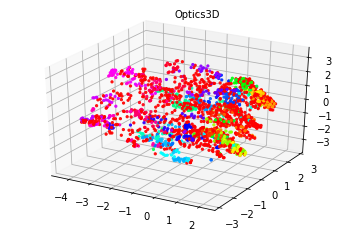

In [1161]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.text2D(0.5, 0.95, 'Optics3D', transform=ax.transAxes)
ax.scatter(new_X[:,0], new_X[:,1], new_X[:,2], c = Y, alpha = 0.9, s = 5)
plt.show()


More Plotting

In [1162]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

In [1163]:
reduced_rate =0.5
        
ncomponents = int(X_train.shape[1] * reduced_rate)
pca = IncrementalPCA(n_components = ncomponents)
data = pca.fit_transform(X_train) 
        
        
db  = OPTICS(min_samples=20).fit(data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        
labels = db.labels_
Y = labels
n_clusters = len(set(Y))- (1 if -1 in Y else 0)
n_noises = list(Y).count(-1)
print('Number of clusters' + str(n_clusters))
print('Number of noises' + str(n_noises))

Number of clusters1
Number of noises688


Text(0.5, 1.0, 'Automatic Clustering\nOPTICS')

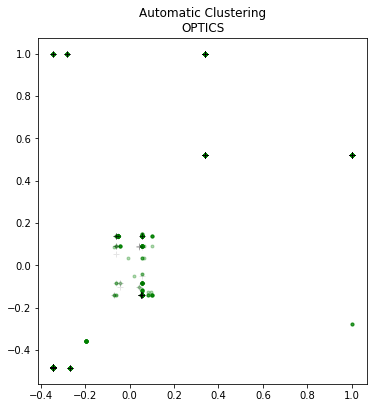

In [1164]:
plt.figure(figsize=(20, 14))
G = gridspec.GridSpec(2, 3)
ax2 = plt.subplot(G[1, 0])

# OPTICS
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = X_train[db.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X_train[db.labels_ == -1, 0], X_train[db.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

In [1165]:
from sklearn.metrics.ranking import roc_curve, auc
from sklearn.metrics.classification import f1_score
from sklearn.svm.classes import SVC
from sklearn.ensemble.forest import RandomForestClassifier

In [1166]:


class AssociationRule:
    def __init__(self, left, right):
        self.left_items = left
        self.right_items = right
        self.scores = []
        
    def length(self):
        return len(self.left_items) + len(self.right_items)
     
    def score(self, index):
        return self.scores[index]
    
    def lhs_string(self):
        return itemset_2_string(self.left_items)
        
    def rhs_string(self):
        return itemset_2_string(self.right_items)
    
    def serialize(self):
        left_key = self.lhs_string()
        right_key = self.rhs_string()
        return left_key + ">" + right_key
    
    @staticmethod        
    def string_2_rule(s):
        subStrings = s.split(">")
        left = string_2_itemset(subStrings[0].strip())
        right = string_2_itemset(subStrings[1].strip())
        #print("AssociationRule(left, right",AssociationRule(left, right))
        return AssociationRule(left, right)

    def append_score(self, score):
        self.scores.append(score)
        
    def get_itemset(self):
        itemset = []
        itemset.extend(self.left_items)
        itemset.extend(self.right_items)
        itemset.sort()
        return itemset
        
        
    def rule_itemset_2_string(self):
        itemset = self.get_itemset()
        return itemset_2_string(itemset)
    
    def compute_basic_probs(self,frequent_itemsets, nTransactions):  
        
        left = frequent_itemsets[self.lhs_string()]
        right = frequent_itemsets[self.rhs_string()]
        
        both = frequent_itemsets[self.rule_itemset_2_string()]
        
        vector = {}
        
        ''' 1. P(A)'''
        p_A = left/nTransactions
        vector['A'] = p_A
        
        ''' 2. P(B)'''
        p_B = right/nTransactions
        vector['B'] = p_B
        
        ''' 3. P(~A)'''
        p_not_A = 1 - p_A
        vector['~A'] = p_not_A
        
        ''' 4. P(~B)'''
        p_not_B = 1 - p_B
        vector['~B'] = p_not_B
        
        ''' 5. P(AB) '''
        p_A_and_B = both/nTransactions
        vector['AB'] = p_A_and_B
        
        ''' 6. P(~AB)'''
        p_not_A_and_B = (right - both)/nTransactions
        vector['~AB'] = p_not_A_and_B
        
        ''' 7. P(A~B)'''
        p_A_and_not_B = (left - both)/nTransactions
        vector['A~B'] = p_A_and_not_B
        
        ''' 8. P(~A~B)'''
        p_not_A_and_not_B = 1 - (left + right - both)/nTransactions
        vector['~A~B'] = p_not_A_and_not_B 
        
        '''
        9. P(A|B)
        '''
        p_A_if_B = p_A_and_B / p_B
        vector['A|B'] = p_A_if_B
        
        '''
        10. P(~A|~B)
        '''
        p_not_A_if_not_B = p_not_A_and_not_B / p_not_B
        vector['~A|~B'] = p_not_A_if_not_B
        
        '''
        11. P(A|~B)
        '''
        p_A_if_not_B = p_A_and_not_B/p_not_B
        vector['A|~B'] = p_A_if_not_B
        
        '''
        12. p(~A|B)
        '''
        p_not_A_if_B = p_not_A_and_B / p_B
        vector['~A|B'] = p_not_A_if_B
        
        '''
        13. P(B|A)
        '''
        p_B_if_A = p_A_and_B / p_A
        vector['B|A'] = p_B_if_A
        
        '''
        14. P(~B|~A)
        '''
        p_not_B_if_not_A = p_not_A_and_not_B / p_not_A
        vector['~B|~A'] = p_not_B_if_not_A
        
        '''
        15. P(B|~A)
        '''
        p_B_if_not_A = p_not_A_and_B/p_not_A
        vector['B|~A'] = p_B_if_not_A
        
        '''
        16. p(~B|A)
        '''
        p_not_B_if_A = p_A_and_not_B / p_A
        vector['~B|A'] = p_not_B_if_A
        
        return vector
    
    def is_redundant_(self, bits, k, itemset, freq_itemset_dict): 
        '''
        Run out of items --> create rule and check format criterion
        '''
        if k >= len(itemset):
            items_1 = []
            items_2 = []
            for index in range(len(bits)):
                if bits[index] == True:
                    items_1.append(itemset[index])
                else:
                    items_2.append(itemset[index])
            for item in items_2:
                rule = AssociationRule(items_1, [item])
                confidence = freq_itemset_dict.getConfidence(rule)
                if confidence == 1: return True
            return False 
      
        value_domain = [True, False]
        for value in value_domain:
            bits[k] = value
            checker = self.is_redundant_(bits, k+1, itemset, freq_itemset_dict)
            if checker == True: return True
            bits[k] = True    
        return False
    
    '''
    Expand an item-set with equivalent items.
    '''
    def is_redundant(self, freq_itemset_dict):
        bits = [True for _ in self.left_items]
        checker = self.is_redundant_(bits, 0, self.left_items, freq_itemset_dict)
        if checker == True: return True
        
        bits =  [True for _ in self.right_items]
        return self.is_redundant_(bits, 0, self.right_items, freq_itemset_dict)
    
    '''
    Check if an item-set is satisfied condition of the rule. 
    '''
    def satisfy_rule(self, itemset, is_lhs = True):
        condition = self.left_items
        if is_lhs == False: condition = self.right_items
        if len(condition) > len(itemset) or len(itemset) == 0:
            return False
        for item in condition:
            if item not in itemset:
                return False
        return True
    

In [1167]:
'''
Created on 14 Feb 2018

@author: danhbuithi
'''

class RelationArray2D(object):
    '''
    classdocs
    '''

    def __init__(self, item_dict, relation_values):
        '''
        Constructor
        '''
        self.item_dict = item_dict
        self.relation_matrix = relation_values
        
        
    def get_value(self, item1, item2):
        i = self.item_dict[item1]
        j = self.item_dict[item2]
        return self.relation_matrix[i, j]
    
    def get_items(self):
        return self.item_dict.keys()
        
    def get_index(self, item):
        return self.item_dict[item]
    
class RelationArray1D(object):
    '''
    classdocs
    '''

    def __init__(self, item_dict, values):
        '''
        Constructor
        '''
        self.item_dict = item_dict
        self.values = values
        
        
    def get_value_at(self, index):
        return self.values[index]
    
    def get_items(self):
        return self.item_dict.keys()
        
    def get_value(self, item):
        return self.item_dict[item]

In [1168]:
# Transaction databases, each transaction is a set of items
import numpy as np
from scipy import sparse
from scipy import stats


class DataSet:
    def __init__(self):
        self.current = 0
        self.train_data = []
        self.data_labels = []
        
    
    def __iter__(self):
        return iter(self.train_data)
                
    def size(self):
        return len(self.train_data)
    
    def get_transaction(self, index):
        return self.train_data[index]
    
    def clear(self):
        self.train_data.clear()
        
    def add_transaction(self, t):
        return self.train_data.append(t) 
        
    '''
    Load data set from a file. The input file must be formated in CSV (comma separated)
    class_index is used in the case of data-set with labels. 
    '''
    def load(self, file_path, class_index = -1, has_header = False):
        self.train_data = []
        if class_index != -1: self.data_labels = []
        
        with open(file_path, "r") as text_in_file:
            if has_header == True:
                text_in_file.readline()
                
            for line in text_in_file:
                #print("dataset script line", line)
                transaction = [x.strip() for x in line.split(',')]
                transaction = list(filter(None, transaction))
                #print("datset script transaction" , transaction)
                
                if (class_index != -1):
                    self.data_labels.append(transaction[class_index])
                    del transaction[class_index]
                
                self.train_data.append(list(set(transaction)))
        print("Loading done")
    '''
    Return number of classes in data (if have).
    '''            
    def number_of_classes(self):
        if self.data_labels == None: return 0
        return len(set(self.data_labels))

    def convert_data_labels(self, inlier_name):
        Y_train = np.zeros(len(self.data_labels))
        for i in range(Y_train.shape[0]):
            if self.data_labels[i] == inlier_name:
                Y_train[i] = 1
            else: 
                Y_train[i] = -1
        return Y_train

    def convert_2_binary_format_with(self, items_dict, classes_dict = None):
        n_items = len(items_dict)
        X_train = np.zeros((self.size(), n_items))
        
        k = 0
        for transaction in self.train_data:
            for item in transaction:
                if item not in items_dict: 
                    print('not in features...')
                    continue
                i = items_dict[item]
                X_train[k, i] = 1.0
            k += 1
            
        Y_train = []
        if classes_dict is not None:
            for label in self.data_labels:
                if label not in classes_dict:
                    print('not in classes')
                    Y_train.append(-1)
                else:
                    Y_train.append(classes_dict[label]) 
        return X_train, np.array(Y_train)        
    
    def get_items_dict_(self):
        attr_dict = {}
        #check existing data
        for transaction in self.train_data:
            for index in range (len(transaction)):
                item_name = transaction[index]
                if item_name not in attr_dict:
                    attr_dict[item_name] = True
        return attr_dict
    
    def get_class_list_(self):
        # Sort items and classes in alphabet order.
        return sorted(set(self.data_labels))
        
        

    '''
    Convert transaction data into binary format
    '''
    def convert_2_binary_format(self):
        
        attr_dict = self.get_items_dict_()
        print("convert_2_binary_format attr_dict", attr_dict)
        """
        {'a6@3': True, 'a7@left': True, 'a9@no': True, 'a3@30-34': True, 'a1@30-39': True, 'class@no': True, 'a5@no': True, 'a4@0-2': True, 'a2@premeno': True, 'a8@left_low': True, 'a8@right_up': True, 'a3@20-24': True, 'a7@right': True, 'a1@40-49': True, 'a6@2': True, 'a8@left_up': True, 'a2@ge40': True, 'a1@60-69': True, 'a3@15-19': True, 'a8@right_low': True, 'a3@0-4': True, 'a3@25-29': True, 'a1@50-59': True, 'a3@50-54': True, 'a8@central': True, 'a6@1': True, 'a3@10-14': True, 'a2@lt40': True, 'a3@40-44': True, 'a3@35-39': True, 'a1@70-79': True, 'a3@5-9': True, 'a9@yes': True, 'a5@yes': True, 'a4@6-8': True, 'a4@9-11': True, 'a4@3-5': True, 'a3@45-49': True, 'a5@?': True, 'a4@15-17': True, 'a4@12-14': True, 'class@yes': True, 'a8@?': True, 'a4@24-26': True}
        
        
        """
         
        # Sort items and classes in alphabet order.
        classes_list = sorted(set(self.data_labels))
        items_list = sorted(attr_dict.keys())
        
        classes_dict = {classes_list[i] : i for i in range(len(classes_list))}
        attr_dict = {items_list[i] : i for i in range(len(items_list))}
        
        #Generate binary matrix (X_train) and array of labels(Y_train)
        X_train, Y_train = self.convert_2_binary_format_with(attr_dict, classes_dict)
                
        return RelationArray2D(attr_dict, sparse.csr_matrix(X_train)), RelationArray1D(classes_dict, np.array(Y_train))
        
    @staticmethod
    def write_relation_matrix_(matrix):
        with open('item_relation.csv', 'w') as file_writer:
            item_names = sorted(matrix.item_dict.keys())
            file_writer.write('o0o,')
            file_writer.write(','.join(item_names))
            file_writer.write('\n')
            for i in range(len(item_names)):
                file_writer.write(item_names[i] + ',')
                file_writer.write(','.join(str(x) for x in matrix.relation_matrix[i].tolist()))
                file_writer.write('\n')
                
                
   
    '''
    This method estimates relationship among items. There're two kinds of relationship
    - Correlation:including negative correlation (<= -0.3) and positive correlation (>= 0.3)
    - Cover: threshold 1.0, including cover (2) and covered (-2) 
    '''
    def items_relationship(self):
        
        print ('Computing item relation matrix...')
        
        X_train, _ = self.convert_2_binary_format()
        
        print("X_train",X_train)
    
        correlation_matrix, p_values = stats.spearmanr(X_train.relation_matrix.todense(), axis = 0)
        
        zeros_mask = (p_values <= 0.05).astype(int)
        small_mask = (np.abs(correlation_matrix) >= 0.1).astype(int)
        
        relation_matrix = correlation_matrix * small_mask * zeros_mask
        
        a = RelationArray2D(X_train.item_dict, relation_matrix)
        DataSet.write_relation_matrix_(a)
        
        return a

In [1169]:
train_data_set = DataSet()

In [1170]:
train_data_set.load("/content/breast_train_transactions.txt", 0, has_header = False)

Loading done


In [1171]:
X_train, Y_train = train_data_set.convert_2_binary_format()

convert_2_binary_format attr_dict {'a3@30-34': True, 'a4@0-2': True, 'a6@3': True, 'a7@left': True, 'a1@30-39': True, 'a5@no': True, 'a2@premeno': True, 'a8@left_low': True, 'a9@no': True, 'a6@2': True, 'a3@20-24': True, 'a7@right': True, 'a8@right_up': True, 'a1@40-49': True, 'a1@60-69': True, 'a2@ge40': True, 'a3@15-19': True, 'a8@left_up': True, 'a3@0-4': True, 'a8@right_low': True, 'a1@50-59': True, 'a3@25-29': True, 'a3@50-54': True, 'a8@central': True, 'a3@10-14': True, 'a2@lt40': True, 'a6@1': True, 'a3@40-44': True, 'a3@35-39': True, 'a1@70-79': True, 'a3@5-9': True, 'a5@yes': True, 'a4@6-8': True, 'a9@yes': True, 'a4@9-11': True, 'a4@3-5': True, 'a3@45-49': True, 'a5@?': True, 'a4@15-17': True, 'a4@12-14': True, 'a8@?': True, 'a4@24-26': True}


In [1172]:
test_data_set = DataSet()
test_data_set.load("/content/breast_test_transactions.txt", 0, has_header = False)
Xtest, Ytest = test_data_set.convert_2_binary_format_with(X_train.item_dict, Y_train.item_dict)
Ytest = Ytest.flatten()

Loading done
not in features...


In [1173]:
class_count = train_data_set.number_of_classes()

In [1174]:
import json
import numpy as np

class IOHelper:

    @staticmethod
    def write_file_in_lines(file_name, data, header = None):
        with open(file_name, "w") as text_file:
            if header is not None:
                text_file.write(header)
                text_file.write('\n')
            for transaction in data:
                text_file.write(transaction)
                text_file.write('\n')
    
    @staticmethod        
    def read_file_in_lines(inputfile, has_header = False):
        data = []
        with open(inputfile, "r") as text_file:
            file_iter = iter(text_file)
            if has_header == True:
                next(file_iter)
            
            for line in file_iter:
                data.append(line.strip())
        return data
    
    @staticmethod
    def read_ranking_file(input_file):
        patterns = []
        ranking = []
        k = 0
        with open(input_file, "r") as text_file:
            for line in text_file:
                subStrings = line.split(';')
                rule_key = subStrings[0].strip()
                patterns.append(rule_key)
                ranking.append([])
                for v in subStrings[1:]:
                    r = int(v)
                    ranking[k].append(r)
                
                k += 1
                if k % 1000 == 0: print(str(k))
        return patterns, np.array(ranking)
    
    @staticmethod 
    def save_as_json_format(file_name, o):
        with open (file_name, 'w') as text_file:
            json.dump(o, text_file)
            
    @staticmethod 
    def save_as_json_format_in_line(file_name, o):
        with open (file_name, 'w') as text_file:
            #json.dump(o, text_file)
            for item in o:
                line = json.dumps(item)
                text_file.write(line)
                text_file.write('\n')
            
    @staticmethod        
    def load_json_object(file_name):
        with open(file_name, 'r') as text_file:
            o = json.load(text_file)
            return o
    
    @staticmethod    
    def write_matrix(file_name, matrix):
        with open(file_name, "w") as text_file:
            for line in matrix:
                text_file.write(','.join(str(x) for x in line.tolist()))
                text_file.write('\n')
    
    @staticmethod
    def write_list_of_tuples(file_name, tuples_list):
        with open(file_name, 'w') as writer:
            for rule in tuples_list:
                writer.write(str(rule))
                writer.write('\n')

In [1175]:
unexpected_rules = IOHelper.load_json_object("/content/unexpected_rule_file_json")

In [1176]:
unexpected_rules

[['a1@50-59,a2@ge40,a4@0-2,a5@no,a6@3,a7@left,a9@no>class@no',
  0.8333333333333334,
  [['a1@50-59,a2@ge40,a3@30-34,a4@0-2,a5@no,a6@3,a7@left,a9@no>class@yes',
    0.9720244168575001,
    1.0,
    1.0],
   ['a1@50-59,a2@ge40,a3@30-34,a5@no,a6@3,a7@left,a9@no>class@yes',
    0.9620316820077568,
    0.5,
    1.0],
   ['a1@50-59,a2@ge40,a3@30-34,a4@0-2,a5@no,a6@3,a7@left,a8@?,a9@no>class@yes',
    0.946437332472341,
    1.0,
    1.0]]],
 ['a2@premeno,a4@0-2,a5@no,a6@1,a7@left,a8@left_low,a9@no>class@no',
  0.875,
  [['a2@premeno,a3@40-44,a4@0-2,a5@no,a6@1,a7@left,a8@left_low,a9@no>class@yes',
    0.957956970372433,
    1.0,
    1.0],
   ['a1@40-49,a2@premeno,a3@40-44,a4@0-2,a5@no,a6@1,a7@left,a8@left_low,a9@no>class@yes',
    0.9497376721731239,
    1.0,
    1.0],
   ['a2@premeno,a3@40-44,a4@0-2,a5@no,a6@1,a7@left,a9@no>class@yes',
    0.9193087112345576,
    0.5,
    1.0]]],
 ['a1@40-49,a2@premeno,a3@30-34,a4@0-2,a5@no,a7@right,a8@left_up,a9@no>class@no',
  1.0,
  [['a2@premeno,a3@30-34,

In [1177]:
def filter_association_rules(unexpected_rules, delta_1 = 0):
    rules = []
    for x in unexpected_rules:
        if x[2][0][1] > delta_1: 
            rules.append(AssociationRule.string_2_rule(x[0]))
    return rules

In [1178]:
def string_2_itemset(key):
    if key == '':
        return []
    else: 
        return key.split(',')

def itemset_2_string(itemset):
    return ",".join(itemset)

def merge_itemsets(itemset_1, itemset_2):
    merged_items = []
    merged_items.extend(itemset_1)
    merged_items.extend(itemset_2)
    merged_items = list(set(merged_items))
    merged_items = sorted(merged_items)
    
    return merged_items

def get_full_path(prefix, file_name):
    if prefix == '': return file_name
    return prefix + '//' + file_name


In [1179]:
refined_unexpected_rules = filter_association_rules(unexpected_rules)

In [1180]:
print('svm testing...')
svc_model = SVC(kernel = 'poly', degree=3, coef0 = 0.1, random_state = 1)
svc_model.fit(X_train.relation_matrix, Y_train.values.flatten())

svm testing...


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.1,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

In [1181]:
def refine_with_unexpectedness(data_set, classes_dict, preY, Ytrue, unexpected_rules):
    
    print('Refine with unexpected rules...')
    y_pred = np.copy(preY)
    for i in range(data_set.size()):
        x = data_set.get_transaction(i)
        for r in unexpected_rules:
            if r.satisfy_rule(x, is_lhs = True):
                label = r.right_items[0]
                y_pred[i] = classes_dict[label]
    print(f1_score(Ytrue, y_pred, average=None))
    if (data_set.number_of_classes() <= 2):
        fpr, tpr, _ = roc_curve(Ytrue, y_pred.flatten())
        print(auc(fpr, tpr))

SVM

In [1182]:
svc_y_pred = svc_model.predict(Xtest)
print(f1_score(Ytest, svc_y_pred, average=None))
if (class_count <= 2):
  fpr, tpr, _ = roc_curve(Ytest, svc_y_pred.flatten())    
  print(auc(fpr, tpr))

[0.91428571 0.72727273]
0.7857142857142857


In [1183]:
refine_with_unexpectedness(test_data_set, Y_train.item_dict, svc_y_pred, Ytest, refined_unexpected_rules)

Refine with unexpected rules...
[0.90909091 0.76923077]
0.8258928571428572


Random Forest

In [1184]:
print('Random forest testing...')
rf_model = RandomForestClassifier(n_estimators=20, random_state=1)
rf_model.fit(X_train.relation_matrix, Y_train.values.flatten())
    
rf_y_pred = rf_model.predict(Xtest)
print(f1_score(Ytest, rf_y_pred, average=None))
if (class_count <= 2):
  fpr, tpr, _ = roc_curve(Ytest, rf_y_pred.flatten())
  print(auc(fpr, tpr))
    
refine_with_unexpectedness(test_data_set, Y_train.item_dict, rf_y_pred, Ytest, refined_unexpected_rules)

Random forest testing...
[0.88571429 0.63636364]
0.734375
Refine with unexpected rules...
[0.90909091 0.76923077]
0.8258928571428572
